# Driving a transmon qubit 
In this tutorial we show how to drive a transmon qubit using pysqkit and how to extract the fidelity of the desired single-qubit gate. 

In [8]:
import numpy as np 
import cmath
import time
from typing import Callable
import matplotlib.pyplot as plt
from pysqkit.qubits import SimpleTransmon
from pysqkit.systems.system import QubitSystem, Qubit
from pysqkit.drives import microwave_drive
from pysqkit.drives.pulses import cos_modulation
from pysqkit.drives.pulse_shapes import gaussian_top
from pysqkit.util.metrics import average_process_fidelity, average_gate_fidelity
from pysqkit.util.phys import temperature_to_thermalenergy
from pysqkit.util.hsbasis import weyl_by_index, weyl
from pysqkit.util.linalg import hilbert_schmidt_prod
import pysqkit.util.transformations as trf
from pysqkit.util.quantum import generalized_rabi_frequency
from pysqkit.solvers import solvkit
from pysqkit.tomography import TomoEnv
import qutip
import matplotlib 
matplotlib.rcParams['mathtext.fontset'] = 'cm'
from IPython.display import display, Latex

A microwave gate for a transmon qubit is based on the following driven Hamiltonian 

$$H = H^{(0)}_T  + H_{drive},$$

$$H^{(0)}_T =  \hbar \omega_T \hat{b}^{\dagger}\hat{b} + \hbar \frac{\delta_T}{2} \hat{b}^{\dagger} \hat{b}^{\dagger}\hat{b} \hat{b},$$


$$\frac{H_{drive}}{h} = \varepsilon_T \cos(2\pi f_d t) \hat{n}_T.$$

The (approximate) charge operator for the transmon in terms of annihilation and creation operators reads

$$
\hat{n}_T = i \biggl( \frac{E_J}{32 |\delta_T |} \biggr)^{1/4} (b^{\dagger} - b),
$$
where 
$$
E_J = \hbar \biggl(\frac{\omega_T - \delta_T}{8 | \delta_T |} \biggr)^2.
$$
Let us introduce the transmon object

In [9]:
temperature = 0.020 #K
thermal_energy = temperature_to_thermalenergy(temperature) # kb T/h in GHz

levels_t = 3
transm = SimpleTransmon(
    label='T',
    max_freq=4.5, #5.0,
    anharm=-0.3,
    diel_loss_tan=0.75*1e-6,
    env_thermal_energy=thermal_energy,
    dim_hilbert=levels_t
)

# We also add the drive 
# In what follows we show two cases: the pulse give as a function or directly as a list 
pulse_as_list = False
if pulse_as_list == False:  
    transm.add_drive(microwave_drive, label='sq_gate', pulse=cos_modulation, 
                     pulse_shape=gaussian_top)

In [11]:
# Setting drive parameters
eps_drive = 0.04
freq_drive = transm.freq
rabi_period = 1/generalized_rabi_frequency(['0', '1'], eps_drive, freq_drive, transm)
t_rise = 5 #5 #ns
t_tot = rabi_period/2 + t_rise #ns (parameters optimized by hand so far) 


pts_per_drive_period = 10
nb_points = int(t_tot*freq_drive*pts_per_drive_period)
t_list = np.linspace(0, t_tot, nb_points)
pulse_list = np.zeros(nb_points)
shape = gaussian_top(t_list, t_rise)

if pulse_as_list == True:
    for k in range(0, nb_points):
        pulse_list[k] = eps_drive*shape[k]*np.cos(2*np.pi*freq_drive*t_list[k])
    transm.add_drive(microwave_drive, label='sq_gate', pulse=pulse_list)
else:
    transm.drives['sq_gate'].set_params(phase=0.0, time=t_list, rise_time=t_rise, amp=eps_drive, freq=freq_drive)

In [12]:
# Setting up simulation
hamil0 = transm.hamiltonian(as_qobj=True)
hamil_drive = [transm.drives['sq_gate'].hamiltonian(as_qobj=True)]
pulse_drive = [transm.drives['sq_gate'].eval_pulse()]
jump_ops = transm.collapse_ops(as_qobj=True)
state_in = transm.state('0', as_qobj=True)[1] 

simu_opt = qutip.solver.Options()
simu_opt.atol = 1e-12
simu_opt.rtol = 1e-10

output = solvkit.integrate(2*np.pi*t_list, state_in, hamil0, hamil_drive, pulse_drive, jump_ops, "mesolve", options=simu_opt) 

Let us now compute the probability of being in $| 0 \rangle$, $| 1 \rangle$, $| 2 \rangle$.

In [13]:
probs = np.zeros([3, nb_points], dtype=float)
for k in range(nb_points):
    for level in range(3):
        state = transm.state(str(level), as_qobj=True)[1]
        probs[level, k] = qutip.expect(state*state.dag(), output.states[k])


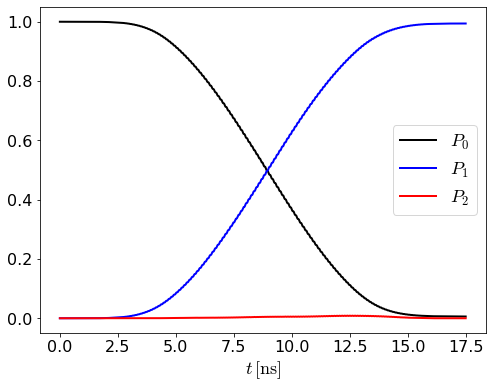

In [14]:
def prob_plot(
    t_list: np.ndarray, 
    probs: np.ndarray, 
    opt: dict={'fs': 18, 'lw': 2.0, 'lw_levels': 3.0, 'ls': 16}
) -> None:
    colors=['black', 'blue', 'red']    
    fig, ax = plt.subplots(figsize=(8, 6))
    for level in range(3):
        ax.plot(t_list, probs[level, :], linewidth=opt['lw'], 
                color=colors[level], label='$P_{}$'.format(str(level)))
    ax.set_xlabel('$t \, [\mathrm{ns}]$', fontsize=opt['fs'])
    ax.tick_params(labelsize=opt['ls'])
    plt.legend(fontsize=opt['fs'])
    plt.show()
    
prob_plot(t_list, probs)      
    
    

Now the previous gate should implement a $Y$ gate on the computational subspace, up to single-qubit phases to be corrected. We now want to obtain the fidelity with respect to this gate.

In [15]:
env_syst = TomoEnv(system=transm, time=2*np.pi*t_list, options=simu_opt)

In [16]:
state_label = ['0', '1']
comp_states = []
for label in state_label:
    comp_states.append(transm.state(label)[1])

In [17]:
# We now perform the tomography
n_process = 4

start = time.time()
sup_op = env_syst.to_super(comp_states, weyl_by_index, n_process)
end = time.time()
print("Computational time = " + str(end - start) + ' s')

Computational time = 0.8932442665100098 s


We now need to obtain the single-qubit correction

In [10]:
def single_qubit_correction(
    sup_op: np.ndarray,
    hs_basis: Callable[[int, int], np.ndarray]
) -> np.ndarray:
    # WARNING: puzzled by sigma minus and sigma plus
    # Not looks correct, but it does not agree with the
    # CZ correction in fluxonium transmon
    #sigma_m = np.array([[0.0, 0.0], [1.0, 0.0]])
    # check why this is not working
    sigma_m = np.array([[0.0, 1.0], [0.0, 0.0]])
    sigma_m_vec = trf.mat_to_vec(sigma_m, hs_basis)
    evolved_sigma_m_vec = sup_op.dot(sigma_m_vec)
    evolved_sigma_m = trf.vec_to_mat(evolved_sigma_m_vec, hs_basis)
    phi = cmath.phase(hilbert_schmidt_prod(sigma_m, evolved_sigma_m))
    p_phi = np.array([[1, 0], [0, np.exp(-1j*phi)]])
    return p_phi

# The analytic correction works...

def analytic_correction(
    freq_drive: float,
    t_tot: float
) -> np.ndarray:
    phi = 2*np.pi*freq_drive*t_tot
    p_phi = np.array([[1, 0], [0, np.exp(1j*phi)]])
    return p_phi
    

#sq_corr = single_qubit_correction(sup_op, weyl_by_index)
sq_corr = analytic_correction(freq_drive, t_tot)
sq_corr_sup = trf.kraus_to_super(sq_corr, weyl_by_index)
total_sup_op = sq_corr_sup.dot(sup_op)

We have obtained the superoperator associated with the single-qubit correction. We now just need to compute the superoperator associated with the desired $Y$ gate.

In [11]:
y = np.array([[0.0, -1j*1.0], [1j*1.0, 0.0]])
y_sup = trf.kraus_to_super(y, weyl_by_index)

We can now calculate the average process fidelity. 

In [12]:
f_pro = average_process_fidelity(y_sup, total_sup_op)
display(Latex(r'$F_{{pro}} = {:.5f}$'.format(f_pro)))

<IPython.core.display.Latex object>

In [13]:
avg_leakage = env_syst.leakage(comp_states)
display(Latex(r'$L_1(\mathcal{{E}} ) = {:.7f}$'.format(avg_leakage)))

<IPython.core.display.Latex object>

In [14]:
f_gate = average_gate_fidelity(y_sup, total_sup_op, avg_leakage)
display(Latex(r'$F_{{gate}} = {:.5f}$'.format(f_gate)))

<IPython.core.display.Latex object>

In what follows we simply rewrite the previous as a function that given a fixed total time varies frequency, strength rise time of the drive to compute a fidelity

In [15]:
def obj_function(
    t_rise: float,
    freq_drive: float, 
    eps_drive: float
) -> float:
    temperature = 0.020 #K
    thermal_energy = temperature_to_thermalenergy(temperature) # kb T/h in GHz

    levels_t = 3
    transm = SimpleTransmon(
        label='T',
        max_freq=5.0,
        anharm=-0.3,
        diel_loss_tan=0.75*1e-6,
        env_thermal_energy=thermal_energy,
        dim_hilbert=levels_t
    )
    transm.add_drive(microwave_drive, label='sq_gate', pulse_shape=gaussian_top)
    
    # Setting drive parameters
    rabi_period = 1/generalized_rabi_frequency(['0', '1'], eps_drive, freq_drive, transm)
    t_tot = rabi_period/2 + t_rise #ns (parameters optimized by hand so far) 
    
    pts_per_drive_period = 10
    nb_points = int(t_tot*freq_drive*pts_per_drive_period)
    t_list = np.linspace(0, t_tot, nb_points)
    transm.drives['sq_gate'].set_params(phase=0.0, time=t_list, 
                                        rise_time=t_rise, amp=eps_drive, freq=freq_drive)
    
    simu_opt = qutip.solver.Options()
    simu_opt.atol = 1e-12
    simu_opt.rtol = 1e-10
    
    env_syst = TomoEnv(system=transm, time=2*np.pi*t_list, options=simu_opt)
    
    state_label = ['0', '1']
    comp_states = []
    for label in state_label:
        comp_states.append(transm.state(label)[1])
    
    
    # We now perform the tomography
    n_process = 4
    
    start = time.time()

    sup_op = env_syst.to_super(comp_states, weyl_by_index, n_process)
    
    end = time.time()
    print("Tomography time = " + str(end - start) + ' s')
    
    def analytic_correction(
        freq_drive: float,
        t_tot: float
    ) -> np.ndarray:
        phi = 2*np.pi*freq_drive*t_tot
        p_phi = np.array([[1, 0], [0, np.exp(1j*phi)]])
        return p_phi
    

    #sq_corr = single_qubit_correction(sup_op, weyl_by_index)
    sq_corr = analytic_correction(freq_drive, t_tot)
    sq_corr_sup = trf.kraus_to_super(sq_corr, weyl_by_index)
    total_sup_op = sq_corr_sup.dot(sup_op)
    
    y = np.array([[0.0, -1j*1.0], [1j*1.0, 0.0]])
    y_sup = trf.kraus_to_super(y, weyl_by_index)
    
    f_pro = average_process_fidelity(y_sup, total_sup_op)
    avg_leakage = env_syst.leakage(comp_states)
    f_gate = average_gate_fidelity(y_sup, total_sup_op, avg_leakage)
    
    return f_gate    

In [16]:
start = time.time()

f_gate_new = obj_function(t_rise=5, freq_drive=transm.freq, eps_drive=0.03)

end = time.time()
print('Computation time = {:.5f}'.format(end - start) + ' s')
display(Latex(r'$F_{{gate}} = {:.5f}$'.format(f_gate_new)))

Tomography time = 0.42630457878112793 s
Computation time = 0.59276 s


<IPython.core.display.Latex object>